In [2]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import sklearn, pandas as pd
import librosa, librosa.display
import sys
import time
from pathlib import Path
import numpy, urllib
import librosa.feature as lf
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
every_composer = ['albeniz', 'beethoven', 'brahms', 'chopin', 'clementi', 'debussy', 'grieg', 'haydn', 'liszt','mendel', 'mozart', 'rachmaninoff', 'schubert', 'schumman','tchaikovsky']




In [5]:
def folder_to_features(folder_name):
    fcl = [lf.spectral_centroid,
    lf.spectral_bandwidth,
    lf.spectral_contrast,
    lf.spectral_rolloff,
    lf.mfcc,
    lf.zero_crossing_rate]
    
    n_mfcc = 12
    audio_time_series_list = []
    song_count = 0
    
    mp3_names =[
        str(p)[len(f'{folder_name}/'):-len('.mp3')] for p in Path().glob(f'{folder_name}/*.mp3')
    ]
    
    for p in Path().glob(f'{folder_name}/*.mp3'):  
        for i in range(10):
            x = librosa.load(p, duration = 5, offset = 5+i*20)[0]
            if x.shape != (0,):
                audio_time_series_list.append(x)
    for song in audio_time_series_list: 
        for f in fcl:
            if f == lf.spectral_centroid:
                feature_i = f(y=song).T
                feature_i = np.hstack((np.mean(feature_i, axis = 0), np.std(feature_i, axis = 0)))
            else:
                current = f(y=song).T
                feature_i = np.hstack((feature_i, np.mean(current, axis = 0), np.std(current, axis = 0)))
        if song_count == 0:
            total_array = feature_i
        else:
            total_array = np.vstack((total_array, feature_i))
        song_count += 1
    label_array = np.full((total_array.shape[0],1), folder_name)
    total_array = np.hstack((label_array, total_array))
    return total_array

In [6]:
def combine_multiple_folder_sets(folder_name_list):
    for folder_data in folder_name_list:
        if folder_data == folder_name_list[0]:
            all_data = folder_to_features(folder_data)
        else:
            all_data = np.vstack((all_data, folder_to_features(folder_data)))
    return all_data

In [7]:
def separate_and_scale_features_and_labels(all_data, frac = 0.05):
    labels, features = np.split(all_data,[1], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, labels,stratify=labels)
    scaler = sklearn.preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [8]:
def try_sgdc(X_train_scaled, X_test_scaled, y_train, y_test):
    model = SGDClassifier(loss='hinge')
    model.fit(X_train_scaled, y_train)
    #predicted_labels = model.predict(X_train_scaled)
    #score_list.append(model.score(X_test_scaled, y_test))
    return model, model.score(X_test_scaled, y_test)

In [9]:
loss_functions = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
def try_sgdc_with_lf(X_train_scaled, X_test_scaled, y_train, y_test, lf):
    model = SGDClassifier(loss=lf, n_iter=20)
    model.fit(X_train_scaled, y_train)
    #predicted_labels = model.predict(X_train_scaled)
    #score_list.append(model.score(X_test_scaled, y_test))
    return model, model.score(X_test_scaled, y_test)

## Getting Data

In [107]:
len(every_composer)

15

In [4]:
all_data = combine_multiple_folder_sets(['albeniz', 'beethoven', 'chopin', 'debussy', 'grieg', 'liszt','mendel', 'mozart', 'rachmaninoff', 'schubert', 'schumman'])
np.save('all_composers_correct', all_data)


NameError: name 'combine_multiple_folder_sets' is not defined

In [ ]:
all_data_for_real.shape

In [ ]:
all_data_for_real = combine_multiple_folder_sets(every_composer)
np.save('all_composers_for_real', all_data_for_real)

In [108]:
df = pd.DataFrame(all_data_for_real)

In [111]:
df.shape

(2343, 63)

In [11]:
counts_by_composer=[296,
    282,
    281,
    206,
    157,
    155,
    141,
    123,
    114,
    109,
    109,
    106,
    94,
    90,
    80]

In [10]:
composers_by_count=['chopin',
    'schubert',
    'beethoven',
    'mozart',
    'haydn',
    'liszt',
    'schumman',
    'albeniz',
    'mendel',
    'clementi',
    'grieg',
    'tchaikovsky',
    'brahms',
    'debussy',
    'rachmaninoff']

In [ ]:
chopin          296
schubert        282
beethoven       281
mozart          206
haydn           157
liszt           155
schumman        141
albeniz         123
mendel          114
clementi        109
grieg           109
tchaikovsky     106
brahms           94
debussy          90
rachmaninoff     80

In [118]:
df[0].value_counts()

chopin          296
schubert        282
beethoven       281
mozart          206
haydn           157
liszt           155
schumman        141
albeniz         123
mendel          114
clementi        109
grieg           109
tchaikovsky     106
brahms           94
debussy          90
rachmaninoff     80
Name: 0, dtype: int64

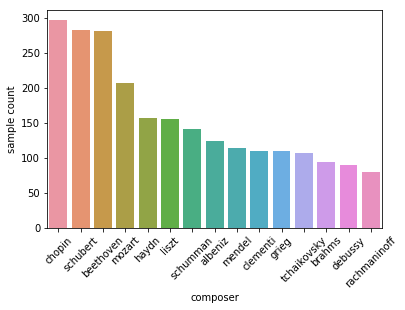

In [21]:
plot=sns.barplot(composers_by_count, counts_by_composer)
plt.setp(plot.get_xticklabels(), rotation=45)
plot.set(xlabel='composer', ylabel='sample count')
plot.figure.savefig('barchart_sample_count_by_composer.png')

In [115]:
296/2343

0.12633376013657704

In [11]:
all_data_for_real = np.load('all_composers_for_real.npy')

## Confusion Matrix Improvement

In [127]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('YlGnBu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


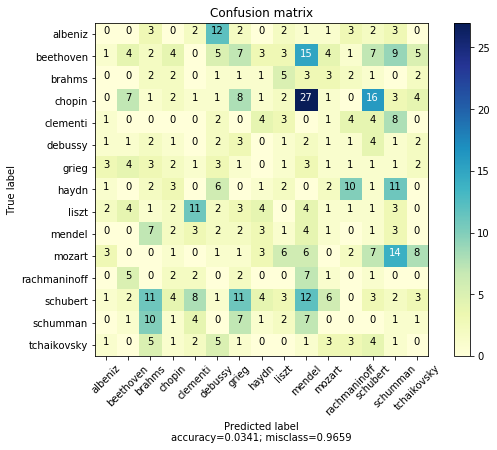

In [78]:
cm = confusion_matrix(y_test_real, model_real.predict(X_test_scaled_real))
plot_confusion_matrix(cm, every_composer,normalize=False)

## start of 'all data for real' model section

### summary of model performances

In [ ]:
{'SGDC':'50','SVM':'64', 'KNN':'51', 'Random Forest':'51', 'XGBoost':'56'}

SGDC with perceptron loss function

50

SVM with rbf kernel, C=10.2
    64
    
KNN with k =1
    51
    
Random Forest with n_estimators=28, max_depth=8, max_features = 'sqrt'
    51
    
XGBoost with booster='dart', lambda=5, alpha=0.5, learning_rate=0.1, max_depth= 6, min_child_weight=5,n_estimators=100,subsample=0.8
    56

### models

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.4931740614334471


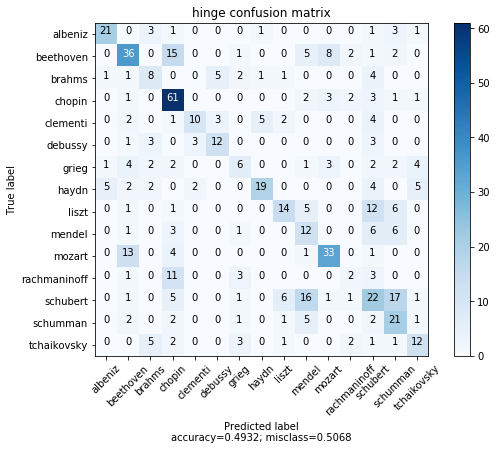

hinge               precision    recall  f1-score   support

     albeniz       0.75      0.68      0.71        31
   beethoven       0.55      0.51      0.53        70
      brahms       0.35      0.35      0.35        23
      chopin       0.56      0.82      0.67        74
    clementi       0.67      0.37      0.48        27
     debussy       0.60      0.55      0.57        22
       grieg       0.33      0.22      0.27        27
       haydn       0.73      0.49      0.58        39
       liszt       0.56      0.36      0.44        39
      mendel       0.26      0.41      0.32        29
      mozart       0.69      0.63      0.66        52
rachmaninoff       0.22      0.10      0.14        20
    schubert       0.32      0.31      0.31        71
    schumman       0.36      0.60      0.45        35
 tchaikovsky       0.48      0.44      0.46        27

   micro avg       0.49      0.49      0.49       586
   macro avg       0.49      0.46      0.46       586
weighted avg       0

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.4232081911262799


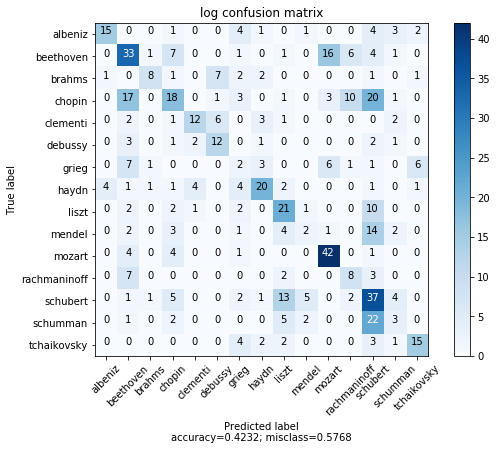

log               precision    recall  f1-score   support

     albeniz       0.75      0.48      0.59        31
   beethoven       0.41      0.47      0.44        70
      brahms       0.67      0.35      0.46        23
      chopin       0.39      0.24      0.30        74
    clementi       0.63      0.44      0.52        27
     debussy       0.46      0.55      0.50        22
       grieg       0.08      0.07      0.08        27
       haydn       0.61      0.51      0.56        39
       liszt       0.40      0.54      0.46        39
      mendel       0.18      0.07      0.10        29
      mozart       0.62      0.81      0.70        52
rachmaninoff       0.30      0.40      0.34        20
    schubert       0.30      0.52      0.38        71
    schumman       0.17      0.09      0.11        35
 tchaikovsky       0.60      0.56      0.58        27

   micro avg       0.42      0.42      0.42       586
   macro avg       0.44      0.41      0.41       586
weighted avg       0.4

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.4726962457337884


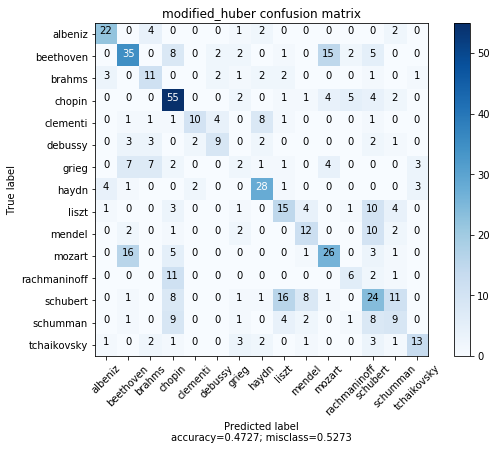

modified_huber               precision    recall  f1-score   support

     albeniz       0.71      0.71      0.71        31
   beethoven       0.52      0.50      0.51        70
      brahms       0.39      0.48      0.43        23
      chopin       0.53      0.74      0.62        74
    clementi       0.71      0.37      0.49        27
     debussy       0.53      0.41      0.46        22
       grieg       0.12      0.07      0.09        27
       haydn       0.61      0.72      0.66        39
       liszt       0.36      0.38      0.37        39
      mendel       0.41      0.41      0.41        29
      mozart       0.52      0.50      0.51        52
rachmaninoff       0.40      0.30      0.34        20
    schubert       0.33      0.34      0.33        71
    schumman       0.26      0.26      0.26        35
 tchaikovsky       0.65      0.48      0.55        27

   micro avg       0.47      0.47      0.47       586
   macro avg       0.47      0.45      0.45       586
weighted av

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.49658703071672355


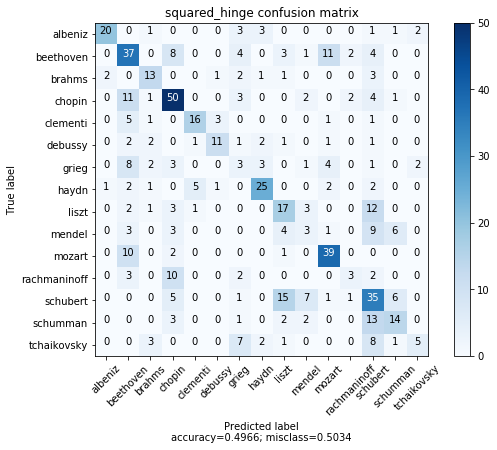

squared_hinge               precision    recall  f1-score   support

     albeniz       0.87      0.65      0.74        31
   beethoven       0.45      0.53      0.48        70
      brahms       0.52      0.57      0.54        23
      chopin       0.57      0.68      0.62        74
    clementi       0.70      0.59      0.64        27
     debussy       0.69      0.50      0.58        22
       grieg       0.11      0.11      0.11        27
       haydn       0.69      0.64      0.67        39
       liszt       0.38      0.44      0.40        39
      mendel       0.16      0.10      0.12        29
      mozart       0.65      0.75      0.70        52
rachmaninoff       0.38      0.15      0.21        20
    schubert       0.36      0.49      0.42        71
    schumman       0.48      0.40      0.44        35
 tchaikovsky       0.56      0.19      0.28        27

   micro avg       0.50      0.50      0.50       586
   macro avg       0.50      0.45      0.46       586
weighted avg

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.49146757679180886


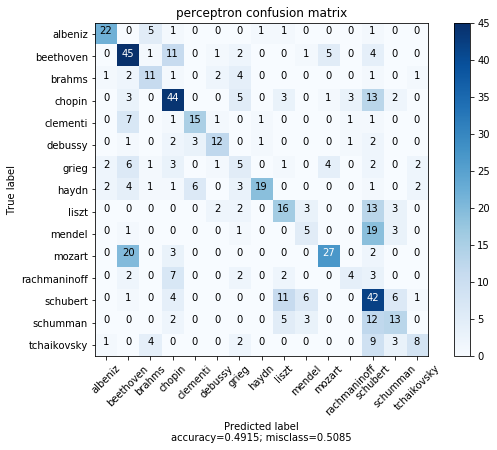

perceptron               precision    recall  f1-score   support

     albeniz       0.79      0.71      0.75        31
   beethoven       0.49      0.64      0.56        70
      brahms       0.48      0.48      0.48        23
      chopin       0.55      0.59      0.57        74
    clementi       0.62      0.56      0.59        27
     debussy       0.63      0.55      0.59        22
       grieg       0.19      0.19      0.19        27
       haydn       0.86      0.49      0.62        39
       liszt       0.41      0.41      0.41        39
      mendel       0.28      0.17      0.21        29
      mozart       0.73      0.52      0.61        52
rachmaninoff       0.44      0.20      0.28        20
    schubert       0.34      0.59      0.43        71
    schumman       0.43      0.37      0.40        35
 tchaikovsky       0.57      0.30      0.39        27

   micro avg       0.49      0.49      0.49       586
   macro avg       0.52      0.45      0.47       586
weighted avg   

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.07679180887372014


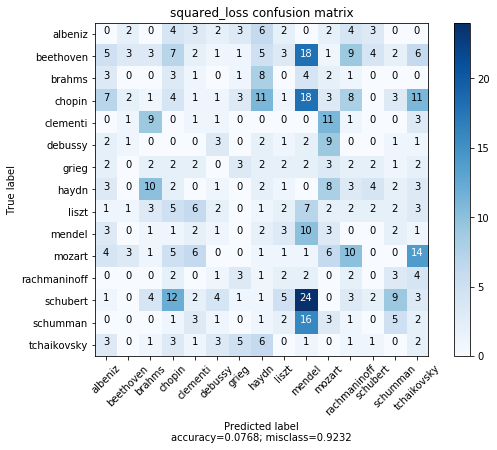

squared_loss               precision    recall  f1-score   support

     albeniz       0.00      0.00      0.00        31
   beethoven       0.23      0.04      0.07        70
      brahms       0.00      0.00      0.00        23
      chopin       0.08      0.05      0.06        74
    clementi       0.03      0.04      0.04        27
     debussy       0.14      0.14      0.14        22
       grieg       0.15      0.11      0.13        27
       haydn       0.04      0.05      0.05        39
       liszt       0.08      0.05      0.06        39
      mendel       0.10      0.34      0.15        29
      mozart       0.11      0.12      0.11        52
rachmaninoff       0.04      0.10      0.06        20
    schubert       0.11      0.03      0.04        71
    schumman       0.17      0.14      0.15        35
 tchaikovsky       0.04      0.07      0.05        27

   micro avg       0.08      0.08      0.08       586
   macro avg       0.09      0.09      0.07       586
weighted avg 

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.15358361774744028


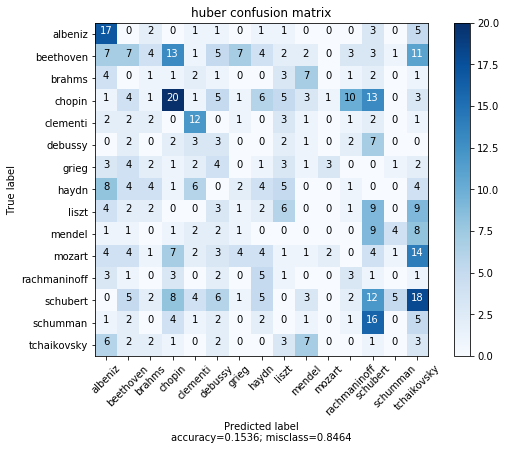

huber               precision    recall  f1-score   support

     albeniz       0.28      0.55      0.37        31
   beethoven       0.17      0.10      0.13        70
      brahms       0.04      0.04      0.04        23
      chopin       0.32      0.27      0.29        74
    clementi       0.32      0.44      0.38        27
     debussy       0.08      0.14      0.10        22
       grieg       0.00      0.00      0.00        27
       haydn       0.12      0.10      0.11        39
       liszt       0.17      0.15      0.16        39
      mendel       0.00      0.00      0.00        29
      mozart       0.33      0.04      0.07        52
rachmaninoff       0.12      0.15      0.13        20
    schubert       0.15      0.17      0.16        71
    schumman       0.00      0.00      0.00        35
 tchaikovsky       0.04      0.11      0.05        27

   micro avg       0.15      0.15      0.15       586
   macro avg       0.14      0.15      0.13       586
weighted avg       0

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.07337883959044368


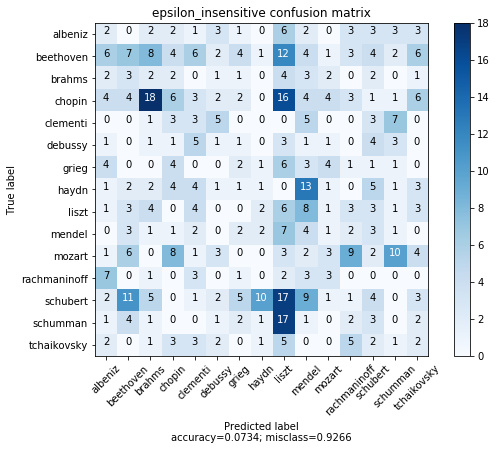

epsilon_insensitive               precision    recall  f1-score   support

     albeniz       0.06      0.06      0.06        31
   beethoven       0.16      0.10      0.12        70
      brahms       0.04      0.09      0.06        23
      chopin       0.16      0.08      0.11        74
    clementi       0.08      0.11      0.10        27
     debussy       0.04      0.05      0.04        22
       grieg       0.09      0.07      0.08        27
       haydn       0.05      0.03      0.03        39
       liszt       0.06      0.15      0.08        39
      mendel       0.06      0.14      0.09        29
      mozart       0.14      0.06      0.08        52
rachmaninoff       0.00      0.00      0.00        20
    schubert       0.10      0.06      0.07        71
    schumman       0.00      0.00      0.00        35
 tchaikovsky       0.06      0.07      0.07        27

   micro avg       0.07      0.07      0.07       586
   macro avg       0.07      0.07      0.07       586
weight

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.04778156996587031


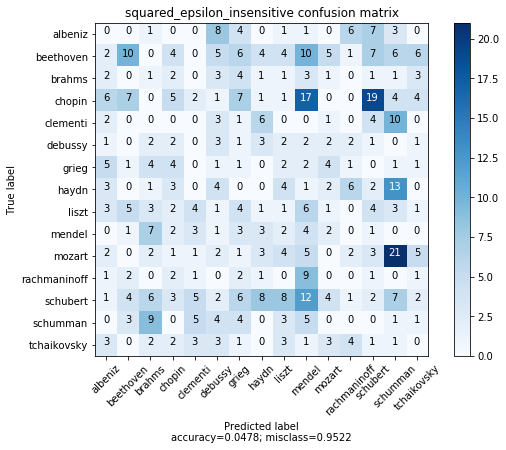

squared_epsilon_insensitive               precision    recall  f1-score   support

     albeniz       0.00      0.00      0.00        31
   beethoven       0.30      0.14      0.19        70
      brahms       0.03      0.04      0.03        23
      chopin       0.16      0.07      0.09        74
    clementi       0.00      0.00      0.00        27
     debussy       0.07      0.14      0.10        22
       grieg       0.02      0.04      0.03        27
       haydn       0.00      0.00      0.00        39
       liszt       0.03      0.03      0.03        39
      mendel       0.05      0.14      0.07        29
      mozart       0.00      0.00      0.00        52
rachmaninoff       0.00      0.00      0.00        20
    schubert       0.04      0.03      0.03        71
    schumman       0.01      0.03      0.02        35
 tchaikovsky       0.00      0.00      0.00        27

   micro avg       0.05      0.05      0.05       586
   macro avg       0.05      0.04      0.04       58

In [12]:
for loss_function in loss_functions:
    #print(loss_function)
    #all_data = np.load('all_composers.npy')
    X_train_scaled_real, X_test_scaled_real, y_train_real, y_test_real, scaler_real = separate_and_scale_features_and_labels(all_data_for_real)
    model_real, score_real = try_sgdc_with_lf(X_train_scaled_real, X_test_scaled_real, np.ravel(y_train_real), np.ravel(y_test_real), loss_function)
    print(score_real)
    cm = confusion_matrix(y_test_real, model_real.predict(X_test_scaled_real))
    plot_confusion_matrix(cm,every_composer,normalize=False,title=f'{loss_function} confusion matrix')
    print(loss_function, classification_report(np.ravel(y_test_real), model_real.predict(X_test_scaled_real)))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6331058020477816
              precision    recall  f1-score   support

     albeniz       0.83      0.81      0.82        31
   beethoven       0.54      0.69      0.60        70
      brahms       0.58      0.61      0.60        23
      chopin       0.67      0.82      0.74        74
    clementi       0.76      0.81      0.79        27
     debussy       0.58      0.32      0.41        22
       grieg       0.42      0.30      0.35        27
       haydn       0.62      0.77      0.69        39
       liszt       0.60      0.64      0.62        39
      mendel       0.27      0.10      0.15        29
      mozart       0.83      0.65      0.73        52
rachmaninoff       0.73      0.40      0.52        20
    schubert       0.59      0.72      0.65        71
    schumman       0.55      0.51      0.53        35
 tchaikovsky       0.85      0.63      0.72        27

   micro avg       0.63      0.63      0.63       586
   macro avg       0.63      0.59      0.59       586
weighte

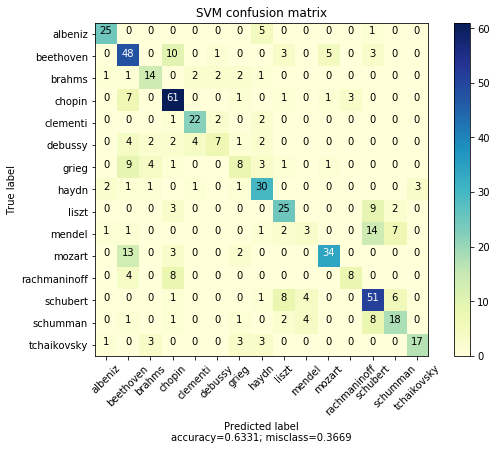

In [126]:
# all_data = np.load('all_composers.npy')
X_train_scaled_real, X_test_scaled_real, y_train_real, y_test_real, scaler_real = separate_and_scale_features_and_labels(all_data_for_real)
# model_small, score_small = try_sgdc(X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small)
# score_small
# print(classification_report(y_test_small, model_small.predict(X_test_scaled_small)))
# confusion_matrix(y_test_small, model_small.predict(X_test_scaled_small))

model = sklearn.svm.SVC(C=10.2)
model.fit(X_train_scaled_real, y_train_real)
print(model.score(X_test_scaled_real, y_test_real))
print(classification_report(y_test_real, model.predict(X_test_scaled_real)))
#print(confusion_matrix(y_test_real, model.predict(X_test_scaled_real)))
cm = confusion_matrix(y_test_real, model.predict(X_test_scaled_real))
plot_confusion_matrix(cm,every_composer,normalize=False,title=f'SVM confusion matrix')


In [41]:
C_values = [0.0001, 0.001, 0.01 ,1, 10, 100, 1000, 10000]

y_pred_prediction = []

for C in C_values:
    svclassifier = sklearn.svm.SVC(kernel='rbf', C = C)  
    svclassifier.fit(X_train_scaled_real, y_train_real) 
    y_pred = svclassifier.predict(X_test_scaled_real)
    y_pred_prediction.append(accuracy_score(y_test_real,y_pred))
    #print(confusion_matrix(y_test,y_pred))  
    #print(classification_report(y_test,y_pred)) 
    print("The accuracy score is" + " "+ str(accuracy_score(y_test_real, y_pred)))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.12627986348122866


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.12627986348122866


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.12627986348122866


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.5870307167235495


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6552901023890785


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6535836177474402


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6535836177474402


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6535836177474402


In [97]:
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6501706484641638
              precision    recall  f1-score   support

     albeniz       0.76      0.71      0.73        31
   beethoven       0.57      0.77      0.66        70
      brahms       0.57      0.70      0.63        23
      chopin       0.70      0.74      0.72        74
    clementi       0.77      0.89      0.83        27
     debussy       0.65      0.68      0.67        22
       grieg       0.64      0.33      0.44        27
       haydn       0.73      0.69      0.71        39
       liszt       0.74      0.72      0.73        39
      mendel       0.33      0.34      0.34        29
      mozart       0.79      0.71      0.75        52
rachmaninoff       0.53      0.50      0.51        20
    schubert       0.58      0.52      0.55        71
    schumman       0.59      0.46      0.52        35
 tchaikovsky       0.81      0.78      0.79        27

   micro avg       0.65      0.65      0.65       586
   macro avg       0.65      0.64      0.64       586
weighte

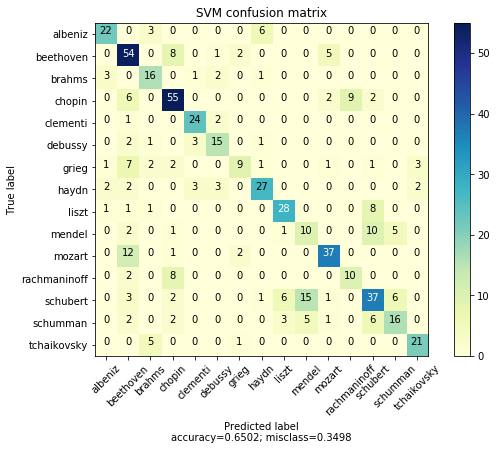

In [100]:
# all_data = np.load('all_composers.npy')
X_train_scaled_real, X_test_scaled_real, y_train_real, y_test_real, scaler_real = separate_and_scale_features_and_labels(all_data_for_real)
# model_small, score_small = try_sgdc(X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small)
# score_small
# print(classification_report(y_test_small, model_small.predict(X_test_scaled_small)))
# confusion_matrix(y_test_small, model_small.predict(X_test_scaled_small))

model = sklearn.svm.SVC(C=10.2)
model.fit(X_train_scaled_real, y_train_real)
print(model.score(X_test_scaled_real, y_test_real))
print(classification_report(y_test_real, model.predict(X_test_scaled_real)))
#print(confusion_matrix(y_test_real, model.predict(X_test_scaled_real)))
cm = confusion_matrix(y_test_real, model.predict(X_test_scaled_real))
plot_confusion_matrix(cm,every_composer,normalize=False,title=f'SVM confusion matrix')

In [104]:
y

array([['784.3863053262704', '137.79125310775652', '758.2677237938899',
        ..., '8.921306441896016', '0.055300112123842594',
        '0.01584334910569111'],
       ['675.4194171057061', '98.12911926900934', '699.0724697942742',
        ..., '7.223843653673994', '0.044243706597222224',
        '0.013698625716786579'],
       ['854.2562059999301', '106.29735625062214', '792.8419415308869',
        ..., '17.076657654453108', '0.061028374565972224',
        '0.015968259547888386'],
       ...,
       ['771.0319055918897', '58.7819938210901', '720.0603977965549',
        ..., '4.483054547325929', '0.056572808159722224',
        '0.007778647748793679'],
       ['939.2091445509158', '140.73096011953166', '945.3438097583291',
        ..., '11.036446560545151', '0.06150987413194445',
        '0.01525742663670677'],
       ['2497.406310253683', '543.313455188582', '3087.892549242019',
        ..., '3.072746041579738', '0.03180028521825397',
        '0.04644843626069269']], dtype='<U32')

In [103]:
label_binarize(y, classes=every_composer)

ValueError: Multioutput target data is not supported with label binarization

In [105]:
X, y = np.split(all_data_for_real,[1], axis=1)

# # Binarize the output
y = label_binarize(y, classes=every_composer)
# n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0, stratify = labels)

classifier = OneVsRestClassifier(sklearn.svm.SVC(C=10.2))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(every_composer)+1):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

ValueError: Multioutput target data is not supported with label binarization

In [26]:
C_values = [10.1,10.2,10.3,10.4]

y_pred_prediction = []

for C in C_values:
    svclassifier = sklearn.svm.SVC(kernel='rbf', C = C)  
    svclassifier.fit(X_train_scaled_real, y_train_real) 
    y_pred = svclassifier.predict(X_test_scaled_real)
    y_pred_prediction.append(accuracy_score(y_test_real,y_pred))
    #print(confusion_matrix(y_test,y_pred))  
    #print(classification_report(y_test,y_pred)) 
    print("The accuracy score is" + " "+ str(accuracy_score(y_test_real, y_pred)))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6126279863481229


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6126279863481229


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6126279863481229


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is 0.6126279863481229


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was

Max Accuracy is 0.505 on test dataset with 1 neighbors.

Training Score: 1.000


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Test score: 0.505


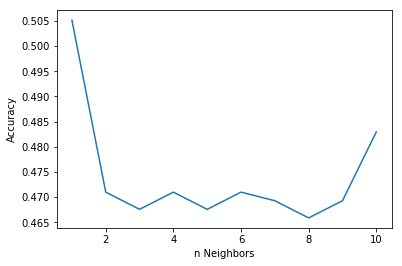

In [85]:
from sklearn.neighbors import KNeighborsClassifier

results_knn=[]
for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled_real,y_train_real)
    results_knn.append(knn.score(X_test_scaled_real,y_test_real))
    
max_accuracy_knn=max(results_knn)
best_k=1+results_knn.index(max(results_knn))
print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(numpy.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")


knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled_real,y_train_real)
print("Training Score: {:.3f}".format(knn.score(X_train_scaled_real,y_train_real)))
print("Test score: {:.3f}".format(knn.score(X_test_scaled_real,y_test_real)))  

Max Accuracy is 0.510 on test dataset with 28 estimators.



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training Score: 0.903
Test score: 0.466
[[20  0  4  0  0  1  0  6  0  1  0  0  1  0  5]
 [ 0 30  4 13  0  1  8  0  2  0  9  5  6  2  0]
 [ 1  0  5  0  0  0  3  2  1  0  0  0  0  0  3]
 [ 1 22  1 46  2  1  4  0  2  5  3 11  9  2  0]
 [ 0  0  0  0 20  3  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  8  0  1  0  0  0  0  0  0  0]
 [ 2  0  1  0  0  0  1  0  0  0  0  0  0  0  1]
 [ 2  3  0  0  1  4  3 26  2  1  1  0  2  0  1]
 [ 0  0  1  1  0  0  0  0 18  2  0  1  4  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0 14  2  5  1  1  3  0  2  3 38  0  5  2  0]
 [ 0  0  0  3  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  1  2  5  0  3  0  1 12 16  0  2 44 25  1]
 [ 0  0  0  1  0  0  0  0  0  1  0  0  0  2  0]
 [ 5  0  3  0  0  0  5  0  0  0  0  0  0  0 14]]


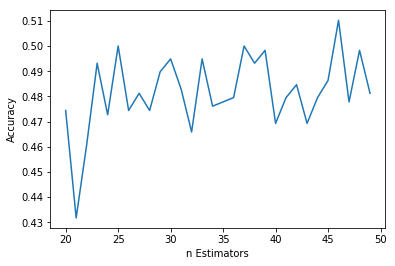

In [88]:
from sklearn.ensemble import RandomForestClassifier
results_forest=[]
for i in range(20,50):
    forest=RandomForestClassifier(n_estimators=i, max_depth=8, max_features = 'sqrt')
    forest.fit(X_train_scaled_real,np.ravel(y_train_real))
    results_forest.append(forest.score(X_test_scaled_real,np.ravel(y_test_real)))
    
max_accuracy_forest=max(results_forest)
best_n_est=2+results_forest.index(max(results_forest))
print("Max Accuracy is {:.3f} on test dataset with {} estimators.\n".format(max_accuracy_forest,best_n_est))

plt.plot(numpy.arange(20,50),results_forest)
plt.xlabel("n Estimators")
plt.ylabel("Accuracy")


forest=RandomForestClassifier(n_estimators=best_n_est, max_depth=8, max_features = 'sqrt')
forest.fit(X_train_scaled_real,y_train_real)
print("Training Score: {:.3f}".format(forest.score(X_train_scaled_real,y_train_real)))
print("Test score: {:.3f}".format(forest.score(X_test_scaled_real,np.ravel(y_test_real))))

print(confusion_matrix(forest.predict(X_test_scaled_real),np.ravel(y_test_real)))

In [87]:
X_train_scaled, X_test_scaled, y_train, y_test, scaler = separate_and_scale_features_and_labels(all_data_for_real)
clf_test = xgb.XGBClassifier(booster = 'dart', reg_lambda = 5, reg_alpha= 0.5,learning_rate =0.1,max_depth= 6, min_child_weight=5,n_estimators=100,subsample=0.8, n_jobs=-1)
clf_test.fit(X_train_scaled, np.ravel(y_train))
training_preds = clf_test.predict(X_train_scaled)
val_preds = clf_test.predict(X_test_scaled)

training_accuracy = accuracy_score(np.ravel(y_train), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Training Accuracy: 99.6%
Validation accuracy: 55.8%


## end of 'all data for real' model section

In [ ]:
try_sgdc(X_train_scaled_small, X_test_scaled_small, np.ravel(y_train_small), np.ravel(y_test_small))

In [ ]:
loss_functions = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
def try_sgdc_with_lf(X_train_scaled, X_test_scaled, y_train, y_test, lf):
    model = SGDClassifier(loss=lf)
    model.fit(X_train_scaled, y_train)
    #predicted_labels = model.predict(X_train_scaled)
    #score_list.append(model.score(X_test_scaled, y_test))
    return model, model.score(X_test_scaled, y_test)

## modified huber performed best

In [ ]:
score_list=[]

In [ ]:
np.mean(np.array(score_list)[:,0])

In [ ]:
average_scores = []
for i in range(len(loss_functions)):
    average_scores.append([loss_functions[i], np.mean(np.array(score_list)[:,i]), np.std(np.array(score_list)[:,i])])

In [ ]:
average_scores

In [ ]:
#score_list

In [ ]:
this_run_scores = []
for loss_function in loss_functions:
    #print(loss_function)
    #all_data = np.load('all_composers.npy')
    X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small, scaler_small = separate_and_scale_features_and_labels(all_data)
    model_small, score_small = try_sgdc_with_lf(X_train_scaled_small, X_test_scaled_small, np.ravel(y_train_small), np.ravel(y_test_small), loss_function)
    print(score_small)
    print(confusion_matrix(y_test_small, model_small.predict(X_test_scaled_small)))
    print(loss_function, classification_report(np.ravel(y_test_small), model_small.predict(X_test_scaled_small)))
    this_run_scores.append(score_small)
score_list.append(this_run_scores)

In [ ]:
# all_data = np.load('all_composers.npy')
X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small, scaler_small = separate_and_scale_features_and_labels(all_data)
# model_small, score_small = try_sgdc(X_train_scaled_small, X_test_scaled_small, y_train_small, y_test_small)
# score_small
# print(classification_report(y_test_small, model_small.predict(X_test_scaled_small)))
# confusion_matrix(y_test_small, model_small.predict(X_test_scaled_small))

model = sklearn.svm.SVC()
model.fit(X_train_scaled_small, y_train_small)
print(model.score(X_test_scaled_small, y_test_small))
print(classification_report(y_test_small, model.predict(X_test_scaled_small)))
print(confusion_matrix(y_test_small, model.predict(X_test_scaled_small)))



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

results_knn=[]
for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled_small,y_train_small)
    results_knn.append(knn.score(X_test_scaled_small,y_test_small))
    
max_accuracy_knn=max(results_knn)
best_k=1+results_knn.index(max(results_knn))
print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(numpy.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")


knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled_small,y_train_small)
print("Training Score: {:.3f}".format(knn.score(X_train_scaled_small,y_train_small)))
print("Test score: {:.3f}".format(knn.score(X_test_scaled_small,y_test_small)))  

# plot_cnf(knn,test_x,test_y,GENRES)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
results_forest=[]
for i in range(20,50):
    forest=RandomForestClassifier(n_estimators=i, max_depth=8, max_features = 'sqrt')
    forest.fit(X_train_scaled_small,np.ravel(y_train_small))
    results_forest.append(forest.score(X_test_scaled_small,np.ravel(y_test_small)))
    
max_accuracy_forest=max(results_forest)
best_n_est=2+results_forest.index(max(results_forest))
print("Max Accuracy is {:.3f} on test dataset with {} estimators.\n".format(max_accuracy_forest,best_n_est))

plt.plot(numpy.arange(20,50),results_forest)
plt.xlabel("n Estimators")
plt.ylabel("Accuracy")


forest=RandomForestClassifier(n_estimators=best_n_est, max_depth=8, max_features = 'sqrt')
forest.fit(X_train_scaled_small,y_train_small)
print("Training Score: {:.3f}".format(forest.score(X_train_scaled_small,y_train_small)))
print("Test score: {:.3f}".format(forest.score(X_test_scaled_small,np.ravel(y_test_small))))

print(confusion_matrix(forest.predict(X_test_scaled_small),np.ravel(y_test_small)))

In [ ]:
['albeniz', 'beethoven', 'chopin', 'debussy', 'grieg', 'liszt','mendel', 'mozart', 'rachmaninoff', 'schubert', 'schumman']




# XGBOOST

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [86]:
clf = xgb.XGBClassifier()
clf.fit(X_train_scaled_small, np.ravel(y_train_small))
training_preds = clf.predict(X_train_scaled_small)
val_preds = clf.predict(X_test_scaled_small)
training_accuracy = accuracy_score(np.ravel(y_train_small), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test_small), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

NameError: name 'X_train_scaled_small' is not defined

In [ ]:
param_grid = {
    "learning_rate": [0.09,0.1,1.1],
    'max_depth': [5,6,7],
    'min_child_weight': [4,5,6],
    'subsample': [0.6,0.7,0.8],
    'n_estimators': [90,100,110],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose = 10)
grid_clf.fit(X_train_scaled_small, np.ravel(y_train_small))

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
# for param_name in sorted(best_parameters.keys()):
#     print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled_small)
val_preds = grid_clf.predict(X_test_scaled_small)
training_accuracy = accuracy_score(np.ravel(y_train_small), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test_small), val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

param_grid = {
    "learning_rate": [0.01,0.1,0.2],
    'max_depth': [2,6,10],
    'min_child_weight': [5,10,15],
    'subsample': [0.6,0.7,0.8],
    'n_estimators': [100, 250,325],
}

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 5
n_estimators: 100
subsample: 0.7

Training Accuracy: 100.0%
Validation accuracy: 57.87%

In [ ]:
grid_clf.cv_results_.keys()

In [ ]:
grid_clf.cv_results_['rank_test_score']

In [ ]:
grid_clf.cv_results_['params'][122]

In [ ]:
param_grid = {
    "learning_rate": [0.09,0.1,1.1],
    'max_depth': [5,6,7],
    'min_child_weight': [4,5,6],
    'subsample': [0.6,0.7,0.8],
    'n_estimators': [90,100,110],

In [ ]:

clf_test = xgb.XGBClassifier(reg_lambda = 5, learning_rate =0.1,max_depth= 6, min_child_weight=5,n_estimators=100,subsample=0.8, n_jobs=-1)
clf_test.fit(X_train_scaled_small, np.ravel(y_train_small))
training_preds = clf_test.predict(X_train_scaled_small)
val_preds = clf_test.predict(X_test_scaled_small)

training_accuracy = accuracy_score(np.ravel(y_train_small), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test_small), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))



In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test, scaler = separate_and_scale_features_and_labels(all_data)
clf_test = xgb.XGBClassifier(booster = 'dart', reg_lambda = 5, reg_alpha= 0.5,learning_rate =0.1,max_depth= 6, min_child_weight=5,n_estimators=100,subsample=0.8, n_jobs=-1)
clf_test.fit(X_train_scaled, np.ravel(y_train))
training_preds = clf_test.predict(X_train_scaled)
val_preds = clf_test.predict(X_test_scaled)

training_accuracy = accuracy_score(np.ravel(y_train), training_preds)
val_accuracy = accuracy_score(np.ravel(y_test), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))



In [ ]:
df = pd.DataFrame(all_data_for_real)

In [ ]:
df.head()

In [ ]:
labels, features = np.split(all_data_for_real,[1], axis=1)

In [ ]:
features.shape

In [ ]:
principal_component_list = []
for i in range(features.shape[1]):
    principal_component_list.append(f'principal component {i+1}')

In [ ]:
features = StandardScaler().fit_transform(features)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21)
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data = principalComponents, columns = principal_component_list[:21])
pca.explained_variance_ratio_

In [ ]:
principalDf.head()

In [ ]:
principal_features = np.array(principalDf)

In [ ]:
data_principal = np.hstack((labels, principal_features))

In [ ]:
np.save('data_principal_21', data_principal)

In [ ]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
print(eig_values)
print(eig_vectors)

In [ ]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print(pc1)
print(pc2)

In [ ]:
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features_titles)
str_loading_1

In [ ]:
str_loading_1.sort_values(ascending=False)

## generating feature titles

In [128]:
mfcc_names = []
for i in range(40):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    mfcc_names.append(f'mfcc {i//2+1} {metric}')

In [129]:
s_contrast_names = []
for i in range(14):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    s_contrast_names.append(f'spectral contrast {i//2+1} {metric}')

In [130]:
s_bandwidth_names = []
for i in range(2):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    s_bandwidth_names.append(f'spectral bandwidth {i//2+1} {metric}')

In [131]:
s_centroid_names = []
for i in range(2):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    s_centroid_names.append(f'spectral centroid {i//2+1} {metric}')

In [132]:
s_rolloff_names = []
for i in range(2):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    s_rolloff_names.append(f'spectral rolloff {i//2+1} {metric}')

In [133]:
zero_crossing_rate_names = []
for i in range(2):
    if i%2 == 0:
        metric = 'mean'
    if i%2 == 1:
        metric = 'std'
    zero_crossing_rate_names.append(f'zero_crossing_rate {i//2+1} {metric}')

In [ ]:
lf.spectral_centroid,
    lf.spectral_bandwidth,
    lf.spectral_contrast,
    lf.spectral_rolloff,
    lf.mfcc,
    lf.zero_crossing_rate

In [134]:
features_titles=s_centroid_names+s_bandwidth_names+s_contrast_names+s_rolloff_names+mfcc_names+zero_crossing_rate_names

In [135]:
features_titles

['spectral centroid 1 mean',
 'spectral centroid 1 std',
 'spectral bandwidth 1 mean',
 'spectral bandwidth 1 std',
 'spectral contrast 1 mean',
 'spectral contrast 1 std',
 'spectral contrast 2 mean',
 'spectral contrast 2 std',
 'spectral contrast 3 mean',
 'spectral contrast 3 std',
 'spectral contrast 4 mean',
 'spectral contrast 4 std',
 'spectral contrast 5 mean',
 'spectral contrast 5 std',
 'spectral contrast 6 mean',
 'spectral contrast 6 std',
 'spectral contrast 7 mean',
 'spectral contrast 7 std',
 'spectral rolloff 1 mean',
 'spectral rolloff 1 std',
 'mfcc 1 mean',
 'mfcc 1 std',
 'mfcc 2 mean',
 'mfcc 2 std',
 'mfcc 3 mean',
 'mfcc 3 std',
 'mfcc 4 mean',
 'mfcc 4 std',
 'mfcc 5 mean',
 'mfcc 5 std',
 'mfcc 6 mean',
 'mfcc 6 std',
 'mfcc 7 mean',
 'mfcc 7 std',
 'mfcc 8 mean',
 'mfcc 8 std',
 'mfcc 9 mean',
 'mfcc 9 std',
 'mfcc 10 mean',
 'mfcc 10 std',
 'mfcc 11 mean',
 'mfcc 11 std',
 'mfcc 12 mean',
 'mfcc 12 std',
 'mfcc 13 mean',
 'mfcc 13 std',
 'mfcc 14 mean',
 '

In [ ]:
index = np.arange(7)
plt.bar(features_titles, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')

In [ ]:
# plotting screeplots 
#print(pca.explained_variance_ratio_)
#print(pca.explained_variance_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')